In [1]:
%matplotlib inline
import os
from glob import glob
from subprocess import PIPE, Popen
import pandas as pd
from IPython.display import Image as IMG
from IPython.core.display import HTML

# Adversarial Attacks

In [2]:
# This is a research competition. Adversarial attacks exploit weaknesses in machine learning
# models where input data can be intentionally perturbed to "fool" the model.
# Understanding the security implications is very important as more decision making
# becomes algorithmic.

In [3]:
# https://www.kaggle.com/c/nips-2017-non-targeted-adversarial-attack/
# https://www.kaggle.com/c/nips-2017-targeted-adversarial-attack/
# https://www.kaggle.com/c/nips-2017-defense-against-adversarial-attack

### Reviewing the Data

In [4]:
ls ../data/

attack_fgsm.py     metadata.json                 sample_attacks/
dataset/           README.md                     sample_attack_submission.zip
dev_toolkit.zip    run_attacks_and_defenses.py   sample_defenses/
download_data.sh*  run_attacks_and_defenses.sh*  sample_targeted_attacks/
inception_v3.ckpt  run_attack.sh*


In [5]:
DATA_DIR = '../data/dataset/'
for fl in sorted(glob(DATA_DIR + '*')):
    p = Popen(['head', '{}'.format(fl)], stdin=PIPE, stdout=PIPE, stderr=PIPE)
    a, b = p.communicate()
    print('#'*30 + ' Head of file: {}'.format(fl))
    for ll in a.decode('utf8').split('\n'):
        print(ll)

############################## Head of file: ../data/dataset/README.md

# Dataset for adversarial competition.

Two datasets will be used for the competition:

* **DEV** dataset which is available here for development and experimenting.
* **TEST** dataset which will be kept secret until after the competition
  and will be used for final scoring.

Both datasets are composed from publicly available images which were posted

############################## Head of file: ../data/dataset/dev_dataset.csv
ImageId,URL,x1,y1,x2,y2,TrueLabel,TargetClass,OriginalLandingURL,License,Author,AuthorProfileURL
0c7ac4a8c9dfa802,https://c1.staticflickr.com/9/8540/28821627444_0524012bdd_o.jpg,0.0,0.0,0.871838111298,1.0,306,779,https://www.flickr.com/photos/gails_pictures/28821627444,https://creativecommons.org/licenses/by/2.0/,gailhampshire,https://www.flickr.com/people/gails_pictures/
f43fbfe8a9ea876c,https://c1.staticflickr.com/9/8066/28892033183_6f675dcc03_o.jpg,0.25,0.0,1.0,0.599757673667,884,378,https

In [6]:
# Above, a script is included to download images... this will take a few mins.
# mkdir images
# python download_images.py --input_file=dev_dataset.csv --output_dir=images
# This will produce a directory of images listed in dev_datasest.csv, each cropped
# and resized and renamed according to dev_dataset.csv

In [7]:
# https://www.kaggle.com/c/nips-2017-defense-against-adversarial-attack#Getting started
# ./download_data.sh

In [8]:
img_df = pd.read_csv(DATA_DIR + 'dev_dataset.csv')

In [9]:
# Inspecting the dataframe, we select an example TrueLabel for comparison
# The objective is to fool an object recognition model with an "adversarial attack"

In [10]:
eagle_imgs = img_df.query('TrueLabel==23').URL.values

In [11]:
IMG(url=eagle_imgs[0])

In [12]:
IMG(url=eagle_imgs[1])

In [13]:
# It is not particularly difficult to change these images making it impossible to correctly
# label the subject as a bald eagle.
# A simple crop can make it difficult to discern the species or to even know there was a bird in the frame.
# However, adversarial attacks should be more subtle, typically making changes that are inperceptible to humans.
# https://blog.openai.com/adversarial-example-research/    "like optical illusions for machines"

## Well-Understood Approaches

In [14]:
# https://www.kaggle.com/benhamner/adversarial-learning-challenges-getting-started
# http://blog.ycombinator.com/how-adversarial-attacks-work/?imm_mid=0f81cc&cmp=em-data-na-na-newsltr_20171115
# https://blog.xix.ai/how-adversarial-attacks-work-87495b81da2d
# Fast Gradient Step Method (FGSM)

### FGSM
*  Add noise to input
*  Classify perturbed image
*  Repeat until misclassified
*  Begin minimizing amplitude of noise s.t. remaining misclassified

In [15]:
# Method relies on simplicity/near-linearity of classification boundary

In [16]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.autograd.gradcheck import zero_gradients
import torchvision.transforms as T
from torchvision.models.inception import inception_v3
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [17]:
classes = img_df.TrueLabel.values
trans = T.Compose([T.ToTensor(), T.Lambda(lambda t: t.unsqueeze(0))])
reverse_trans = lambda x: np.asarray(T.ToPILImage()(x))

In [18]:
eps = 2 * 8 / 225.
steps = 40
norm = float('inf')
step_alpha = 0.0001
model = inception_v3(pretrained=True, transform_input=True).cuda()
loss = nn.CrossEntropyLoss()
model.eval();

/home/funk/anaconda3/lib/python3.6/site-packages/torchvision-0.1.9-py3.6.egg/torchvision/models/inception.py:65: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.


In [19]:
def load_image(img_path):
    img = trans(Image.open(img_path).convert('RGB'))
    return img

In [20]:
def get_class(img):
    x = Variable(img, volatile=True).cuda()
    cls = model(x).data.max(1)[1].cpu().numpy()[0]
    return classes[cls]

In [21]:
def draw_result(img, noise, adv_img):
    fig, ax = plt.subplots(1, 3, figsize=(15, 10))
    orig_class, attack_class = get_class(img), get_class(adv_img)
    ax[0].imshow(reverse_trans(img[0]))
    ax[0].set_title('Original image: {}'.format(orig_class))
    ax[1].imshow(noise[0].cpu().numpy().transpose(1, 2, 0))
    ax[1].set_title('Attacking noise')
    ax[2].imshow(reverse_trans(adv_img[0]))
    ax[2].set_title('Adversarial example: {}'.format(attack_class))
    for i in range(3):
        ax[i].set_axis_off()
    plt.tight_layout()
    plt.show()

In [22]:
def non_targeted_attack(img):
    img = img.cuda()
    label = torch.zeros(1, 1).cuda()
    x, y = Variable(img, requires_grad=True), Variable(label)
    for step in range(steps):
        zero_gradients(x)
        out = model(x)
        y.data = out.data.max(1)[1]
        _loss = loss(out, y)
        _loss.backward()
        normed_grad = step_alpha * torch.sign(x.grad.data)
        step_adv = x.data + normed_grad
        adv = step_adv - img
        adv = torch.clamp(adv, -eps, eps)
        result = img + adv
        result = torch.clamp(result, 0.0, 1.0)
        x.data = result
    return result.cpu(), adv.cpu()

## How Inception "sees" a Panda under perturbation...

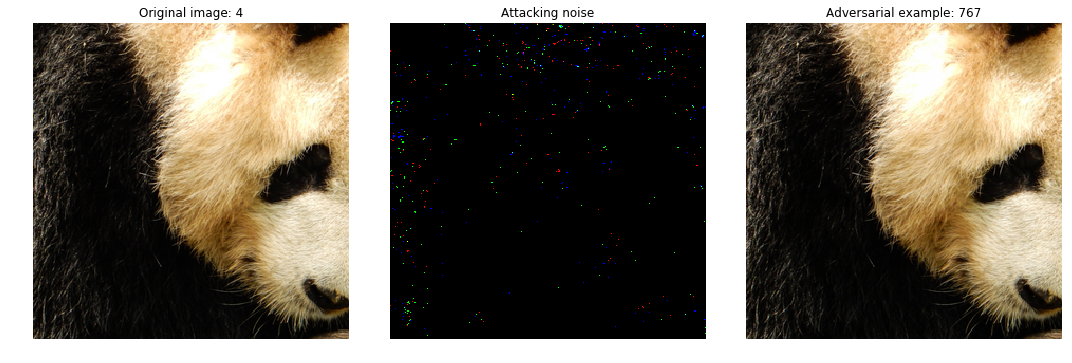

In [23]:
img = load_image(DATA_DIR + 'images/000b7d55b6184b08.png')
adv_img, noise = non_targeted_attack(img)
draw_result(img, noise, adv_img)

## What is Label 767? 

In [24]:
IMG(url=img_df.query('TrueLabel==767').URL.values[0])

In [25]:
# It appears that we have perturbed the panda image enough to confuse Inception into recognize it
# as an image of pork or lamb roasting on the spit.

## Model Assumptions
* Model Gradients available

## Defensive Limitations
* Gradient Masking

In [26]:
# Gradient Masking attempts to withold gradient information offering an adversary only the most likely class label
# Due to robustness of object recognition, an attacker can train adversarial examples with gradients and expect 
# a robust transfer to other models.
# Adversarial attacks tend to be robust to medium as well... Can print hard copy of successful adversarial example 

## Further Directions
* Port tutorial to Tensorflow or use Cleverhans
* Explore additional techniques from Kaggle contest